# Evaluation on Image pairs

In [1]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import seaborn as sns
from PIL import Image

from utils.plotting import showFlow, overlaySegment
from utils.encoding import dice_coeff
from utils.layers import warpImage, warp
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.preprocessing import preprocessing_flownet, preprocessing_pwc


import time

import warnings
warnings.filterwarnings('ignore')

import time
import tracemalloc
# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '3'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f94978b6b20>, 'NVIDIA GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

# Load models

In [2]:
W,H = (150,150)
o_m = H//4 +1
o_n = W//4 +1
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
disp_hw = 5
displace_range = 11

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features
    
    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(4)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(pad2(ssd_minconv)))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    
    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [3]:
baseline = cv2.optflow.DualTVL1OpticalFlow_create()

In [4]:
"""
seq_classic = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                                  torch.nn.BatchNorm2d(32),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                                  torch.nn.BatchNorm2d(32),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                                  torch.nn.BatchNorm2d(64),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                                  torch.nn.Sigmoid())
seq_classic.load_state_dict(torch.load("models/Experiment_1/seq_16_mix_12_01_22-16-51.pth"))
seq_classic.eval().cuda()

seq_kc = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                                  torch.nn.BatchNorm2d(32),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                                  torch.nn.BatchNorm2d(32),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                                  torch.nn.BatchNorm2d(64),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                                  torch.nn.Sigmoid())
seq_kc.load_state_dict(torch.load("models/Experiment_2/seq_16_kd_13_01_22-08-03.pth"))
seq_kc.eval().cuda()

seq_dml = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                                  torch.nn.BatchNorm2d(32),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                                  torch.nn.BatchNorm2d(32),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                                  torch.nn.BatchNorm2d(64),
                                  torch.nn.PReLU(),
                                  torch.nn.Conv2d(64,16,kernel_size=1,stride=1,padding=0,dilation=1),
                                  torch.nn.Sigmoid())
seq_dml.load_state_dict(torch.load("models/Experiment_3/13_01_22-12-44/student_16_2.pth"))
seq_dml.eval().cuda()
"""

path_to_state_dict = "models/Experiment_1/obel16_mix_WL_06_01_22-11-38.pth"
model_classic = OBELISK2d(16)
model_classic.load_state_dict(torch.load(path_to_state_dict))
model_classic.eval().cuda()

path_to_state_dict = "models/Experiment_2/obel_16_KD_WL_20_01_22-12-54.pth"
model_kc = OBELISK2d(16)
model_kc.load_state_dict(torch.load(path_to_state_dict))
model_kc.eval().cuda()

path_to_state_dict = "models/Experiment_3/27_10_21-10-59/student_16_1.pth"
model_dml = OBELISK2d(16)
model_dml.load_state_dict(torch.load(path_to_state_dict))
model_dml.eval().cuda()

OBELISK2d(
  (layer0): Conv2d(1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (batch0): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
)

In [5]:
path = '/share/data_ultraschall/nicke_ma/data'

frames1 = torch.load(os.path.join(path,'test_frames.pth'))
segs1 = torch.load(os.path.join(path,'test_segs.pth')) *2

frames1 = frames1[:-20]
segs1 = segs1[:-20]

frames2 = torch.load(os.path.join(path,'test_frames_disp_6.pth'))
segs2 = torch.load(os.path.join(path,'test_segs_disp_6.pth')) * 2

In [6]:
frames = torch.cat((frames1,frames2))
segs = torch.cat((segs1,segs2))

In [7]:
def warp_baseline(torch_flow, moving_seg):
    """
    function to warp segs with predicted flow

    torch_flow: troch.tensor predicted flow [1 x 2 x 150 x 150]
    seg: torch.tensor [150 x 150]

    return warped_segmentation torch.tensor [150 x 150]
    """

    B, C, H, W = torch_flow.size()
    # mesh grid
    xx = torch.arange(0, W).view(1, -1).repeat(H, 1)
    yy = torch.arange(0, H).view(-1, 1).repeat(1, W)
    xx = xx.view(1, 1, H, W).repeat(B, 1, 1, 1)
    yy = yy.view(1, 1, H, W).repeat(B, 1, 1, 1)
    grid = torch.cat((xx, yy), 1).float()

    vgrid = grid + torch_flow

    # scale grid to [-1,1]
    vgrid[:, 0, :, :] = 2.0 * vgrid[:, 0, :, :].clone() / max(W - 1, 1) - 1.0
    vgrid[:, 1, :, :] = 2.0 * vgrid[:, 1, :, :].clone() / max(H - 1, 1) - 1.0

    vgrid = vgrid.permute(0, 2, 3, 1)
    warped_seg_grid = nn.functional.grid_sample(moving_seg.float().unsqueeze(0).unsqueeze(0), vgrid)
    return warped_seg_grid
    
def eval_baseline(fixed, moving, fixed_seg, moving_seg):
    """
    evaluate dual-tvl1 on image pair

    return  torch.tensor d0 dice of vein and artery
            run_time: float
    """
    
    # prepare for baseline
    in1 = fixed.view(H,W,1).numpy().astype(np.float32)
    in2 = moving.view(H,W,1).numpy().astype(np.float32)
    
    start = time.time()
    # run baseline
    baseline_flow = baseline.calc(in1,in2,None)
    end = time.time()
    run_time = round(end-start, 4)
    
    # warp 
    warped_moving_seg = warp_baseline(torch.from_numpy(baseline_flow.T).unsqueeze(0), moving_seg)
    d0 = dice_coeff(fixed_seg, warped_moving_seg, 3)
    return d0, run_time

In [8]:
def eval_pdd(model, fixed, moving, fixed_seg, moving_seg):
    """
    function to warp segmentations with PDD-Net

    model: instance of torch.nn.Module
    fixed: torch.tensor of size (HxW)
    moving: torch.tensor of size (HxW)
    fixed_seg: torch.tensor of siez (HxW)
    moving_seg: torch.tensor of siez (HxW)

    return: troch.tensor dice score and float runtime
    """

    model.eval()
    
    start = time.time()
    feat1 = model(fixed)
    feat2 = model(moving)
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150))
    end = time.time()
    run_time = round(end-start, 4)


    identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False)
    warped_student_seg = F.grid_sample(moving_seg.float(),identity+flow.cpu().permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    d0 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
    return d0, run_time

In [9]:
baseline_score = torch.zeros(len(frames), 2)
baseline_time = torch.zeros(len(frames))

c_score = torch.zeros(len(frames), 2)
c_time = torch.zeros(len(frames))

kd_score = torch.zeros(len(frames), 2)
kd_time = torch.zeros(len(frames))

dml_score = torch.zeros(len(frames), 2)
dml_time = torch.zeros(len(frames))

seq_c_score = torch.zeros(len(frames), 2)
seq_c_time = torch.zeros(len(frames))

seq_kd_score = torch.zeros(len(frames), 2)
seq_kd_time = torch.zeros(len(frames))

seq_dml_score = torch.zeros(len(frames), 2)
seq_dml_time = torch.zeros(len(frames))


un_score = torch.zeros(len(frames), 2)

counter = 0
for idx, imgs in enumerate(frames):
    fixed = imgs[0].cuda()
    moving = imgs[1].cuda()
    
    fixed_seg = segs[idx][0]
    moving_seg = segs[idx][1]
       
    
    un_score[idx] = dice_coeff(fixed_seg,moving_seg,3)
    #baseline_score[idx], baseline_time[idx] = eval_baseline(fixed.cpu(), moving.cpu(), fixed_seg, moving_seg)
    
    # Obelisk
    c_score[idx], c_time[idx] = eval_pdd(model_classic,fixed.unsqueeze(0).unsqueeze(0).float(), moving.unsqueeze(0).unsqueeze(0).float(), fixed_seg, moving_seg.unsqueeze(0).unsqueeze(0))
    kd_score[idx], kd_time[idx] = eval_pdd(model_kc,fixed.unsqueeze(0).unsqueeze(0).float(), moving.unsqueeze(0).unsqueeze(0).float(), fixed_seg, moving_seg.unsqueeze(0).unsqueeze(0))
    dml_score[idx], dml_time[idx] = eval_pdd(model_dml,fixed.unsqueeze(0).unsqueeze(0).float(), moving.unsqueeze(0).unsqueeze(0).float(), fixed_seg, moving_seg.unsqueeze(0).unsqueeze(0))
    
    # Sequential
    #seq_c_score[idx], seq_c_time[idx] = eval_pdd(seq_classic,fixed.unsqueeze(0).unsqueeze(0).float(), moving.unsqueeze(0).unsqueeze(0).float(), fixed_seg, moving_seg.unsqueeze(0).unsqueeze(0))
    #seq_kd_score[idx], seq_kd_time[idx] = eval_pdd(seq_kc,fixed.unsqueeze(0).unsqueeze(0).float(), moving.unsqueeze(0).unsqueeze(0).float(), fixed_seg, moving_seg.unsqueeze(0).unsqueeze(0))
    #seq_dml_score[idx], seq_dml_time[idx] = eval_pdd(seq_dml,fixed.unsqueeze(0).unsqueeze(0).float(), moving.unsqueeze(0).unsqueeze(0).float(), fixed_seg, moving_seg.unsqueeze(0).unsqueeze(0))
    

In [10]:
frame_pairs = dml_score.shape[0]

In [11]:
print("Unwarped:")
print("Vene: ",un_score[:,0].mean(),un_score[:,0].var())
print("Artery: ", un_score[:,1].mean(),un_score[:,1].var())
print("Overall: ", un_score.mean(),un_score.var())
print()
print("Classic")
print("Vene: ",c_score[:,0].mean(),c_score[:,0].var())
print("Artery: ", c_score[:,1].mean(),c_score[:,1].var())
print("Overall: ", c_score.mean(),c_score.var())
print()
print("KD:")
print("Vene: ",kd_score[:,0].mean(),kd_score[:,0].var())
print("Artery: ", kd_score[:,1].mean(),kd_score[:,1].var())
print("Overall: ", kd_score.mean(),kd_score.var())
print()
print("DML")
print("Vene: ",dml_score[:,0].mean(),dml_score[:,0].var())
print("Artery: ", dml_score[:,1].mean(),dml_score[:,1].var())
print("Overall: ", dml_score.mean(),dml_score.var())

Unwarped:
Vene:  tensor(0.4984) tensor(0.1536)
Artery:  tensor(0.7666) tensor(0.0551)
Overall:  tensor(0.6325) tensor(0.1221)

Classic
Vene:  tensor(0.5612) tensor(0.1605)
Artery:  tensor(0.8502) tensor(0.0328)
Overall:  tensor(0.7057) tensor(0.1173)

KD:
Vene:  tensor(0.5241) tensor(0.1405)
Artery:  tensor(0.8050) tensor(0.0339)
Overall:  tensor(0.6646) tensor(0.1068)

DML
Vene:  tensor(0.5248) tensor(0.1496)
Artery:  tensor(0.7966) tensor(0.0391)
Overall:  tensor(0.6607) tensor(0.1127)


In [12]:
print("Sequential!!")
print()
print("Classic")
print("Vene: ",seq_c_score[:,0].mean(),seq_c_score[:,0].var())
print("Artery: ", seq_c_score[:,1].mean(),seq_c_score[:,1].var())
print("Overall: ", seq_c_score.mean(),seq_c_score.var())
print()
print("KD:")
print("Vene: ",seq_kd_score[:,0].mean(),seq_kd_score[:,0].var())
print("Artery: ", seq_kd_score[:,1].mean(),seq_kd_score[:,1].var())
print("Overall: ", seq_kd_score.mean(),seq_kd_score.var())
print()
print("DML")
print("Vene: ",seq_dml_score[:,0].mean(),seq_dml_score[:,0].var())
print("Artery: ", seq_dml_score[:,1].mean(),seq_dml_score[:,1].var())
print("Overall: ", seq_dml_score.mean(),seq_dml_score.var())

Sequential!!

Classic
Vene:  tensor(0.) tensor(0.)
Artery:  tensor(0.) tensor(0.)
Overall:  tensor(0.) tensor(0.)

KD:
Vene:  tensor(0.) tensor(0.)
Artery:  tensor(0.) tensor(0.)
Overall:  tensor(0.) tensor(0.)

DML
Vene:  tensor(0.) tensor(0.)
Artery:  tensor(0.) tensor(0.)
Overall:  tensor(0.) tensor(0.)


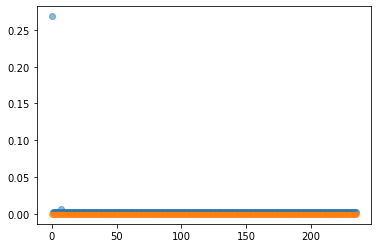

In [13]:
plt.scatter(np.arange(frame_pairs), c_time, alpha=0.5)
plt.scatter(np.arange(frame_pairs), seq_c_time, alpha=0.5)
plt.plot(np.arange(frame_pairs), np.full(frame_pairs, c_time.mean().item()))
plt.plot(np.arange(frame_pairs), np.full(frame_pairs, seq_c_time.mean().item()))

Text(0, 0.5, 'Dice Score')

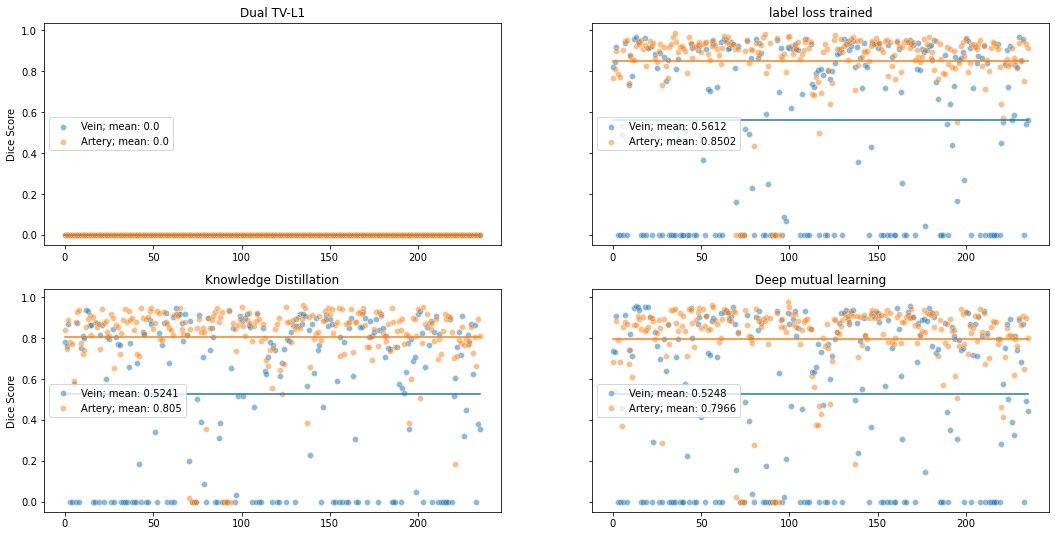

In [14]:
fig, ax = plt.subplots(2,2, figsize=(18,9), sharey=True)

# LABELLOSS
sns.scatterplot(np.arange(c_score.shape[0]), c_score[:,0], ax=ax[0][1], alpha=0.5, label=f'Vein; mean: {round(c_score[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(c_score.shape[0]), c_score[:,1],ax=ax[0][1], alpha=0.5, label=f'Artery; mean: {round(c_score[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,c_score[:,0].mean()), ax=ax[0][1])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,c_score[:,1].mean()), ax=ax[0][1])
ax[0][1].legend(loc='center left')
ax[0][1].set_title('label loss trained')

# BASELINE
sns.scatterplot(np.arange(c_score.shape[0]), baseline_score[:,0], ax=ax[0][0], alpha=0.5, label=f'Vein; mean: {round(baseline_score[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(c_score.shape[0]), baseline_score[:,1],ax=ax[0][0], alpha=0.5, label=f'Artery; mean: {round(baseline_score[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,baseline_score[:,0].mean()), ax=ax[0][0])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,baseline_score[:,1].mean()), ax=ax[0][0])
ax[0][0].set_title('Dual TV-L1')
ax[0][0].legend(loc='center left')

# KD
sns.scatterplot(np.arange(c_score.shape[0]), kd_score[:,0], ax=ax[1][0], alpha=0.5, label=f'Vein; mean: {round(kd_score[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(c_score.shape[0]), kd_score[:,1],ax=ax[1][0], alpha=0.5, label=f'Artery; mean: {round(kd_score[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,kd_score[:,0].mean()), ax=ax[1][0])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,kd_score[:,1].mean()), ax=ax[1][0])
ax[1][0].legend(loc='center left')
ax[1][0].set_title('Knowledge Distillation')

# DML
sns.scatterplot(np.arange(c_score.shape[0]), dml_score[:,0], ax=ax[1][1], alpha=0.5, label=f'Vein; mean: {round(dml_score[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(c_score.shape[0]), dml_score[:,1],ax=ax[1][1], alpha=0.5, label=f'Artery; mean: {round(dml_score[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,dml_score[:,0].mean()), ax=ax[1][1])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,dml_score[:,1].mean()), ax=ax[1][1])
ax[1][1].legend(loc='center left')
ax[1][1].set_title('Deep mutual learning')


ax[0][0].set_ylabel('Dice Score')
ax[1][0].set_ylabel('Dice Score')

In [15]:
print(f"Dual-TVL1: mean: {round(baseline_score.mean().item() * 100,2)}, vein_var: {round(baseline_score[:,0].var().item(), 4)*100}, artery Var {round(baseline_score[:,1].var().item(),4)*100}, overall_var {round(baseline_score.var().item(),4)*100}")
print(f"label_loss: mean: {round(c_score.mean().item(), 4)*100}, vein_var: {round(c_score[:,0].var().item(), 4)*100}, artery Var {round(c_score[:,1].var().item(), 4)*100}, overall_var {round(c_score.var().item(),4)*100}")
print(f"KC: mean: {round(kd_score.mean().item(), 4)*100}, vein_var: {round(kd_score[:,0].var().item(), 4)*100}, artery Var {round(kd_score[:,1].var().item(), 4)*100}, overall_var {round(kd_score.var().item(),4)*100}")
print(f"DML: mean: {round(dml_score.mean().item(), 4)*100}, vein_var: {round(dml_score[:,0].var().item(), 4)*100}, artery Var {round(dml_score[:,1].var().item(),4)*100}, overall_var {round(dml_score.var().item(),4)*100}")

Dual-TVL1: mean: 0.0, vein_var: 0.0, artery Var 0.0, overall_var 0.0
label_loss: mean: 70.57, vein_var: 16.05, artery Var 3.2800000000000002, overall_var 11.73
KC: mean: 66.46, vein_var: 14.05, artery Var 3.39, overall_var 10.68
DML: mean: 66.07, vein_var: 14.96, artery Var 3.91, overall_var 11.27


# Soft target evaluation

In [10]:
soft_model = OBELISK2d(16)
soft_model.load_state_dict(torch.load("models/Experiment_2/obel16_ensemble_soft_27_10_21-13-26.pth"))
soft_model=soft_model.cuda()

In [11]:
pwc = load_pwcnet().cuda()
flownet = load_flownet2().cuda()

In [13]:
def pdd_warp(model, fixed, moving, fixed_seg, moving_seg):
    model.eval()
    
    start = time.time()
    feat1 = model(fixed.unsqueeze(0).unsqueeze(0).cuda())
    feat2 = model(moving.unsqueeze(0).unsqueeze(0).cuda())
    ssd_distance = correlation_layer(displace_range, feat2, feat1)
    soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4 +1, W//4 +1)
    # scaling
    flow=F.interpolate(disp_xy,size=(150,150))
    end = time.time()
    run_time = round(end-start, 4)
    
    identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
    warped_student_seg = F.grid_sample(moving_seg.unsqueeze(0).unsqueeze(0).float().cuda(),identity+flow.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

    return warped_student_seg, run_time


def flownet_warp(fixed, moving, fixed_seg, moving_seg):
    scale=4
    B,C,H,W = fixed.shape
    teacher_fixed = F.interpolate(fixed, size=(4*64,4*64), mode='bicubic')
    teacher_moving = F.interpolate(moving, size=(4*64,4*64), mode='bicubic')
    # Generate the teacher flow estimation
    flow_in = preprocessing_flownet(teacher_fixed.reshape(scale*64,scale*64,1),teacher_moving.reshape(scale*64,scale*64,1))
    
    start = time.time()
    
    flownet_flow = flownet(flow_in.cuda()).cpu()
    
    end = time.time()
    run_time = end-start
    
    flownet_flow = F.interpolate(flownet_flow, size=(H,W), mode='bicubic')

    # warp segmentation with flownet flow
    warped_flownet_seg = warp(moving_seg.float().unsqueeze(0).unsqueeze(0), flownet_flow)
    
    return warped_flownet_seg, run_time

def pwc_warp(fixed, moving, fixed_seg, moving_seg):
    scale=4
    B,C,H,W = fixed.shape
    
    teacher_fixed = F.interpolate(fixed, size=(scale*64,scale*64), mode='bicubic')
    teacher_moving = F.interpolate(moving, size=(scale*64,scale*64), mode='bicubic')

    # Generate the teacher flow estimation
    pwc_flow_in = preprocessing_pwc(teacher_fixed.detach().clone().reshape(scale*64,scale*64,1),teacher_moving.detach().clone().reshape(scale*64,scale*64,1))
    
    start = time.time()
    pwc_flow = pwc(pwc_flow_in.cuda()).cpu()
    pwc_flow = pwc_flow[0] * 20.0
    
    end = time.time()
    run_time = end-start
    
    pwc_flow = F.interpolate(pwc_flow.unsqueeze(0), size=(H,W)).cpu()

    # warp the segmentations with pwc flow
    warped_pwc_seg = warp(moving_seg.float().unsqueeze(0).unsqueeze(0), pwc_flow).cpu()
    
    return warped_pwc_seg, run_time
    

In [14]:
base_segs = torch.zeros(segs.shape)
pwc_segs = torch.zeros(segs.shape)
flow_segs = torch.zeros(segs.shape)


base_time = torch.zeros(frames.shape[0])
pwc_time = torch.zeros(frames.shape[0])
flow_time = torch.zeros(frames.shape[0])


base_dice = torch.zeros(frames.shape[0],2)
pwc_dice = torch.zeros(frames.shape[0],2)
flow_dice = torch.zeros(frames.shape[0],2)

for i, imgs in enumerate(frames):
    fixed = imgs[0]
    moving = imgs[1]
    
    fixed_seg = segs[i][0]
    moving_seg = segs[i][1]
    
    #print(dice_coeff(fixed_seg,moving_seg, 3))
    
    # BASELINE (PDD on Soft targets)
    
    base_seg, run_time_base = pdd_warp(soft_model, fixed.float(), moving.float(), fixed_seg, moving_seg)
    base_segs[i] = base_seg.detach().cpu()
    base_time[i] = run_time_base
    base_dice[i] = dice_coeff(fixed_seg.cpu(), base_seg.cpu(), 3)
    
    
    # FLOWNET2
    warped_seg, run_time = flownet_warp(fixed.unsqueeze(0).unsqueeze(0),
                                         moving.unsqueeze(0).unsqueeze(0),
                                         fixed_seg,
                                         moving_seg)
    
    flow_segs[i] = warped_seg.detach().cpu()
    flow_time[i] = run_time
    flow_dice[i] = dice_coeff(fixed_seg.cpu(), warped_seg, 3).cpu()
    
    # PWC
    warped_seg, run_time = pwc_warp(fixed.unsqueeze(0).unsqueeze(0),
                                     moving.unsqueeze(0).unsqueeze(0),
                                     fixed_seg,
                                     moving_seg)
    pwc_segs[i] = warped_seg.detach().cpu()
    pwc_time[i] = run_time
    pwc_dice[i] = dice_coeff(fixed_seg.cpu(), warped_seg, 3).cpu()

In [16]:
frame_pairs=base_dice.shape[0]

Text(0, 0.5, 'Dice Score')

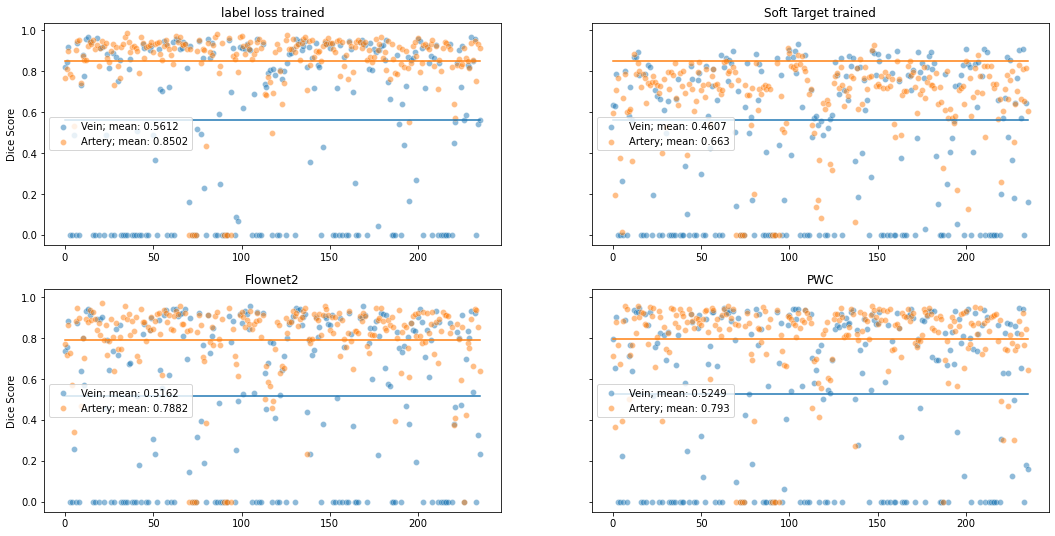

In [21]:
fig, ax = plt.subplots(2,2, figsize=(18,9), sharey=True)

# Soft Target
sns.scatterplot(np.arange(base_dice.shape[0]), base_dice[:,0], ax=ax[0][1], alpha=0.5, label=f'Vein; mean: {round(base_dice[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(base_dice.shape[0]), base_dice[:,1],ax=ax[0][1], alpha=0.5, label=f'Artery; mean: {round(base_dice[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,c_score[:,0].mean()), ax=ax[0][1])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,c_score[:,1].mean()), ax=ax[0][1])
ax[0][1].legend(loc='center left')
ax[0][1].set_title('Soft Target trained')

# LABELLOSS
sns.scatterplot(np.arange(c_score.shape[0]), c_score[:,0], ax=ax[0][0], alpha=0.5, label=f'Vein; mean: {round(c_score[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(c_score.shape[0]), c_score[:,1],ax=ax[0][0], alpha=0.5, label=f'Artery; mean: {round(c_score[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,c_score[:,0].mean()), ax=ax[0][0])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,c_score[:,1].mean()), ax=ax[0][0])
ax[0][0].legend(loc='center left')
ax[0][0].set_title('label loss trained')

# Flownet
sns.scatterplot(np.arange(flow_dice.shape[0]), flow_dice[:,0], ax=ax[1][0], alpha=0.5, label=f'Vein; mean: {round(flow_dice[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(flow_dice.shape[0]), flow_dice[:,1],ax=ax[1][0], alpha=0.5, label=f'Artery; mean: {round(flow_dice[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,flow_dice[:,0].mean()), ax=ax[1][0])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,flow_dice[:,1].mean()), ax=ax[1][0])
ax[1][0].legend(loc='center left')
ax[1][0].set_title('Flownet2')

# PWC
sns.scatterplot(np.arange(pwc_dice.shape[0]), pwc_dice[:,0], ax=ax[1][1], alpha=0.5, label=f'Vein; mean: {round(pwc_dice[:,0].mean().item(), 4)}')
sns.scatterplot(np.arange(pwc_dice.shape[0]), pwc_dice[:,1],ax=ax[1][1], alpha=0.5, label=f'Artery; mean: {round(pwc_dice[:,1].mean().item(), 4)}')
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,pwc_dice[:,0].mean()), ax=ax[1][1])
sns.lineplot(np.arange(frame_pairs), np.full(frame_pairs,pwc_dice[:,1].mean()), ax=ax[1][1])
ax[1][1].legend(loc='center left')
ax[1][1].set_title('PWC')

ax[0][0].set_ylabel('Dice Score')
ax[1][0].set_ylabel('Dice Score')

soft target trained model performs worse than teachers :(

In [22]:
print(f"PDD-soft: mean: {round(base_dice.mean().item(),4)*100}, vein_var: {round(base_dice[:,0].var().item(), 4)*100}, artery Var {round(base_dice[:,1].var().item(),4)*100}, overall_var {round(base_dice.var().item(),4)*100}")
print(f"PDD: mean: {round(c_score.mean().item(), 4)*100}, vein_var: {round(c_score[:,0].var().item(), 4)*100}, artery Var {round(c_score[:,1].var().item(), 4)*100}, overall_var {round(c_score.var().item(),4)*100}")
print(f"Flownet2: mean: {round(flow_dice.mean().item(), 4)*100}, vein_var: {round(flow_dice[:,0].var().item(), 4)*100}, artery Var {round(flow_dice[:,1].var().item(), 4)*100}, overall_var {round(flow_dice.var().item(),4)*100}")
print(f"PWC: mean: {round(pwc_dice.mean().item(), 4)*100}, vein_var: {round(pwc_dice[:,0].var().item(), 4)*100}, artery Var {round(pwc_dice[:,1].var().item(),4)*100}, overall_var {round(pwc_dice.var().item(),4)*100}")

PDD-soft: mean: 56.19, vein_var: 12.870000000000001, artery Var 4.08, overall_var 9.48
PDD: mean: 70.57, vein_var: 16.05, artery Var 3.2800000000000002, overall_var 11.73
Flownet2: mean: 65.22, vein_var: 14.649999999999999, artery Var 4.06, overall_var 11.19
PWC: mean: 65.9, vein_var: 15.2, artery Var 4.26, overall_var 11.51


# Runtime
between Flownet2, PWC-Net and PDD-Net

findfont: Font family ['Latin Modern Roman'] not found. Falling back to DejaVu Sans.


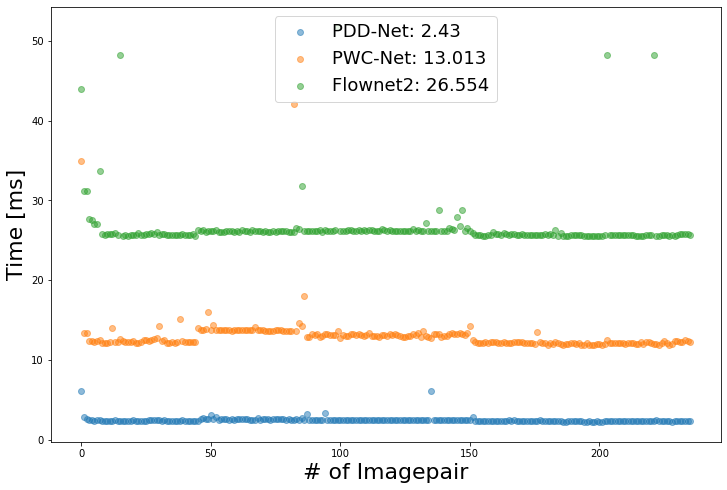

In [17]:
fonts = {'fontsize': 22,'family': 'Latin Modern Roman'}
plt.figure(figsize=(12,8))
plt.scatter(np.arange(frame_pairs), base_time * 1000, label=f'PDD-Net: {round(base_time.mean().item()*1000, 3)}', alpha=0.5)
plt.scatter(np.arange(frame_pairs), pwc_time * 1000, label=f'PWC-Net: {round(pwc_time.mean().item()*1000, 3)}', alpha=0.5)
plt.scatter(np.arange(frame_pairs), flow_time * 1000, label=f'Flownet2: {round(flow_time.mean().item()*1000, 3)}', alpha=0.5)
plt.legend(fontsize=18)
plt.ylabel("Time [ms]", fontdict=fonts)
plt.xlabel("# of Imagepair", fontdict=fonts)
plt.show()

In [ ]:
diff_vein = flow_dice[:,0]- pwc_dice[:,0]
diff_art = flow_dice[:,1]- pwc_dice[:,1]

In [ ]:
plt.scatter(np.arange(diff_vein.shape[0]), diff_vein)

In [ ]:
plt.scatter(np.arange(diff_art.shape[0]), diff_art)